<div style="background: linear-gradient(45deg, #ffa900, #afcd95, #3eb8a5); padding: 20px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 32px;"> BERT Mediated Sentiment Analysis of IMDB Movie Reviews</h1>  
    
</div>

Table Of Contents:
1. Coding Environment Prepararation  
2. Data Download  
    2.1 Tokenize Dataset  
    2.2 Dataset Processing   
3. Pre-Trained BERT Model  
    3.1. Dataset Processing for BERT Model
4. BERT Model Training   
    4.1. Trained Model Save & Load   
    4.2. Trained BERT Model Evaluation  
5. Mixed Sentiments Identification by trained BERT Model
6. Modules & Packages Used In The Jupyter Notebook   

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Coding Environment Prepararation</h1>  
</div>

In [ ]:
# Install datasets library of HuggingFace
!pip install datasets

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn

import torch
from torch import nn
from transformers import BertModel
from transformers import BertTokenizer
from transformers import BertConfig
from transformers import BertForSequenceClassification

from transformers import AdamW, get_scheduler
from datasets import load_dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
# Setting random seeds for reproducible results
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Data Download </h1>  
</div>

In [4]:
# load_dataset is function of datasets library of HuggingFace
dataset = load_dataset('imdb')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

**Remarks:**
- Dataset contains train_dataset, test_dataset, and unsupervised_dataset dictionaries with the respective dataset splits.
    - Individual data samples can be accessed using these splits.

In [5]:
# Check data content as pandas DF
pd.DataFrame({'text':dataset['train'][:10]['text'],
              'label':dataset['train'][:10]['label']})

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
5,I would put this at the top of my list of film...,0
6,Whoever wrote the screenplay for this movie ob...,0
7,"When I first saw a glimpse of this movie, I qu...",0
8,"Who are these ""They""- the actors? the filmmake...",0
9,This is said to be a personal film for Peter B...,0


<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Tokenize Dataset </h1>  
</div>

In [6]:
# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Check how “tokenizer” object work
input_1 = 'I love korean food!'
tokenizer.tokenize(input_1)

['i', 'love', 'korean', 'food', '!']

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Pre-Trained BERT Model </h1>  
</div>

In [8]:
# Load BERT for sequence classification with binary label output
# Output classes: positive and negative, thus num_labels = 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2)
# Move model to the correct device
# Define the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Dataset Processing for BERT Model </h1>  
</div>

In [9]:
# Split dataset into train/test
train_ds = dataset['train']
test_ds = dataset['test']

In [10]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [11]:
# Function to preprocess the text into tokens
def preprocess_function(examples):
    return tokenizer(examples['text'],
                     padding = True,
                     truncation = True,
                     return_tensors = 'pt')

In [12]:
# Tokenize dataset
tokenized_train_ds = train_ds.map(preprocess_function, batched = True)
tokenized_test_ds = test_ds.map(preprocess_function, batched = True)

In [13]:
# Subsample datasets by select() for faster training
train_dataset = tokenized_train_ds.shuffle(seed = 42).select(range(5000))
test_dataset = tokenized_test_ds.shuffle(seed = 42).select(range(1500))

def format_dataset(batch):
    # Convert the labels and the inputs to PyTorch tensors
    batch['label'] = torch.tensor(batch['label'])
    batch['input_ids'] = torch.tensor(batch['input_ids'])
    batch['attention_mask'] = torch.tensor(batch['attention_mask'])
    return batch

# Apply the formatting to the dataset
train_dataset = train_dataset.map(format_dataset)
test_dataset = test_dataset.map(format_dataset)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [14]:
# Used collate_fn to ensure batch data is handled correctly
def collate_fn(batch):
    # Stack the input_ids, attention_mask, and labels into tensors
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])

    return {'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels}

In [15]:
# Pass collate_fn to the DataLoader to ensure proper batching of data
train_dataloader = DataLoader(train_dataset, batch_size = 8,
                              shuffle = True,
                              collate_fn = collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = 8,
                             collate_fn = collate_fn)

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> BERT Model Training </h1>  
</div>

In [16]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

# Define the learning rate scheduler
num_training_steps = len(train_dataloader) * 3 # 3 epochs
lr_scheduler = get_scheduler('linear',
                             optimizer = optimizer,
                             num_warmup_steps = 0,
                             num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Training loop
model.train()

for epoch in range(3): # Train for 3 epochs
    progress_bar = tqdm(train_dataloader, desc = f"Training Epoch {epoch + 1}")

    for batch in progress_bar:
        # Move inputs and labels to appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels = labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss = loss.item())

Training Epoch 3: 100%|██████████| 625/625 [07:45<00:00,  1.34it/s, loss=0.0158]


<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Trained Model Save & Load </h1>  
</div>

In [18]:
# Save the trained model
model.save_pretrained('imdb-trained-bert')

In [19]:
# Save the tokenizer
tokenizer.save_pretrained('imdb-trained-bert')

('imdb-trained-bert/tokenizer_config.json',
 'imdb-trained-bert/special_tokens_map.json',
 'imdb-trained-bert/vocab.txt',
 'imdb-trained-bert/added_tokens.json')

In [20]:
# Load saved tokenizer
tokenizer = BertTokenizer.from_pretrained('imdb-trained-bert')

In [21]:
# Load saved model
model = BertForSequenceClassification.from_pretrained('imdb-trained-bert')

In [22]:
# Check model configuration
print(model.config)

BertConfig {
  "_name_or_path": "imdb-trained-bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [23]:
# Move model to the correct device after loading the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Trained BERT Model Evaluation </h1>  
</div>

In [24]:
# Set the model to evaluation mode
model.eval()

all_predictions = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs to appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get predictions
        outputs = model(input_ids = input_ids,
                        attention_mask = attention_mask)

        # Get logits
        logits = outputs.logits
        # Get predicted class (argmax)
        predictions = torch.argmax(logits, dim = -1)

        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [25]:
# Generate classification report
report = classification_report(all_labels,
                               all_predictions,
                               target_names = ['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       762
    Positive       0.91      0.92      0.91       738

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



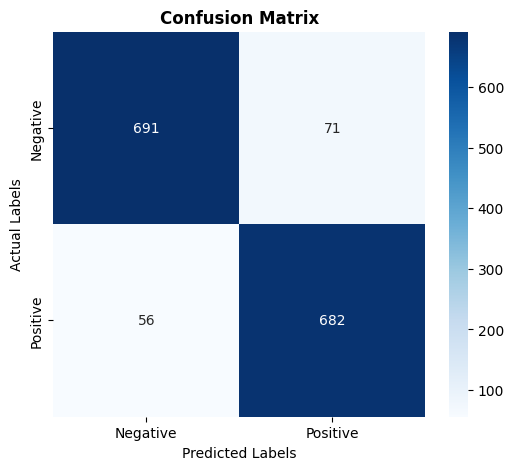

In [26]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Negative', 'Positive'],
            yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix', fontweight = 'bold')
plt.show()

<div style="background: linear-gradient(45deg, #3eb8a5, #afcd95); padding: 15px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Mixed Sentiments Identification by trained BERT Model </h1>  
</div>

## Approach: Rule-Based Detection Using Sentence Splitting
1. Sentencize the review, which means splitting the review into individual sentences.
2. Perform sentiment analysis on each sentence.
3. The review is classified as mixed when there are both positive and negative sentences.

In [27]:
# To download the necessary tokenizer data
import nltk
nltk.download('punkt') # To download the necessary tokenizer data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
# Define function to classify reviews into 3 classes based on logits
def classify_review_mixed(review):
    # Tokenize the review into sentences
    sentences = nltk.sent_tokenize(review)
    pos_count = 0
    neg_count = 0

    # Classify each sentence
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors = 'pt', 
                           padding = True, truncation = True, 
                           max_length = 512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            
            # Get the prediction (0: Negative, 1: Positive)
            # Convert tensor to scalar
            prediction = torch.argmax(logits, dim = -1).item()

        # Increment counts based on prediction
        if prediction == 1:
            pos_count += 1

        else:
            neg_count += 1

    # Threshold logic to determine 'Mixed'
    if pos_count > 0 and neg_count > 0:
        return 'Mixed'
    elif pos_count > 0:
        return 'Positive'
    else:
        return 'Negative'

In [29]:
# Example reviews
reviews = ['The movie was great. But the ending was disappointing.', # Should be Mixed
           'I loved the acting. But I hated the plot.', # Should be Mixed
           'The plot was dull, and the acting was bad.', # Should be Negative
           'An excellent movie with great performances.', # Should be Positive
           'This movie was fantastic! I loved it. However, the ending was quite confusing.',
           'I did not enjoy this film. It was boring and poorly executed.',
           'An average experience, nothing special. But not completely bad.']

for review in reviews:
    sentiment = classify_review_mixed(review)
    print(f'Review: {review}')
    print(f'Overall Sentiment: {sentiment}')
    print('-' * 90)

Review: The movie was great. But the ending was disappointing.
Overall Sentiment: Mixed
------------------------------------------------------------------------------------------
Review: I loved the acting. But I hated the plot.
Overall Sentiment: Mixed
------------------------------------------------------------------------------------------
Review: The plot was dull, and the acting was bad.
Overall Sentiment: Negative
------------------------------------------------------------------------------------------
Review: An excellent movie with great performances.
Overall Sentiment: Positive
------------------------------------------------------------------------------------------
Review: This movie was fantastic! I loved it. However, the ending was quite confusing.
Overall Sentiment: Mixed
------------------------------------------------------------------------------------------
Review: I did not enjoy this film. It was boring and poorly executed.
Overall Sentiment: Negative
-------------